# Sampling: First example

This example shows you how to perform Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html).

It follows on from [Optimisation: First example](./optimisation-first-example.ipynb)

Like in the optimisation example, we start by importing pints:

In [1]:
import pints

Next, we create a model class. 

Instead of using a real model, in this example we use the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, we choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, we can now generate some toy data:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 25
values = org_values + np.random.normal(0, noise, org_values.shape)

We can use matplotlib (or any other plotting package) to look at the data we've created:

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

<Figure size 1200x450 with 1 Axes>

Now we have enough data (a model, a list of times, and a list of data) to formulate a problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

We now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, we need to add a _noise model_. One way to do this is using the `UnknownNoiseLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

This noise has mean zero, and an unknown standard deviation. How can we find out the standard deviation? By inferring it along with the other parameters. This means we have added one parameter to our problem!

In [10]:
print('Original problem dimension: ' + str(problem.n_parameters()))

Original problem dimension: 2


In [11]:
print('New dimension: ' + str(log_likelihood.n_parameters()))

New dimension: 3


(This means we also have to update our vector of true parameters)

In [12]:
true_parameters += [noise]
print(true_parameters)

[0.015, 500, 25]


This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

We can use this in a Bayesian inference scheme to find the quantity we're interested in:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, we now define a _prior_, indicating our initial ideas about what the parameters should be. 
Just as we're using a _log-likelihood_ (the natural logarithm of a likelihood), we'll define this using a _log-prior_. This simplifies the above equation to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example we'll assume we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [13]:
log_prior = pints.UniformLogPrior(
    [0.01, 400, 1],
    [0.02, 600, 100]
    )

With this prior, we can now define the numerator of Bayes' rule -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$:

In [14]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [15]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [16]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
20    63     0.0952    0.0476    0.0952     0:00.0
40    123    0.122     0.0244    0.0976     0:00.0
60    183    0.082     0.0164    0.0656     0:00.1
80    243    0.0741    0.0123    0.0494     0:00.1
100   303    0.0693    0.0099    0.0396     0:00.1
120   363    0.0579    0.00826   0.0413     0:00.1
140   423    0.0496    0.00709   0.0426     0:00.1
160   483    0.0435    0.0124    0.0435     0:00.1
180   543    0.0387    0.0166    0.0387     0:00.1
Initial phase completed.
200   603    0.0348    0.0149    0.0348     0:00.1
220   663    0.0498    0.0271    0.0407     0:00.1
240   723    0.083     0.0705    0.083      0:00.2
260   783    0.0996    0.119

3100  9303   0.231     0.222     0.236      0:02.0
3120  9363   0.231     0.222     0.236      0:02.1
3140  9423   0.231455  0.222     0.236      0:02.1
3160  9483   0.231     0.223     0.237      0:02.1
3180  9543   0.230745  0.222     0.237      0:02.1
3200  9603   0.231     0.223     0.236      0:02.1
3220  9663   0.232     0.222     0.236      0:02.1
3240  9723   0.231     0.222     0.237      0:02.1
3260  9783   0.231     0.223     0.237      0:02.2
3280  9843   0.23      0.223     0.237      0:02.2
3300  9903   0.23      0.223     0.237      0:02.2
3320  9963   0.23      0.223     0.237      0:02.2
3340  10023  0.229572  0.222     0.237      0:02.2
3360  10083  0.23      0.221     0.237      0:02.2
3380  10143  0.231     0.222     0.237      0:02.2
3400  10203  0.231     0.221     0.238      0:02.3
3420  10263  0.23      0.220988  0.237      0:02.3
3440  10323  0.23      0.221     0.236      0:02.3
3460  10383  0.231     0.222     0.23577    0:02.3
3480  10443  0.232     0.223   

6420  19263  0.234     0.226756  0.233      0:04.2
6440  19323  0.233     0.226     0.233      0:04.2
6460  19383  0.233     0.227     0.232317   0:04.2
6480  19443  0.233     0.227     0.233      0:04.3
6500  19503  0.233     0.226     0.233      0:04.3
6520  19563  0.233     0.226     0.233      0:04.3
6540  19623  0.232839  0.226     0.233      0:04.3
6560  19683  0.233     0.226     0.232      0:04.3
6580  19743  0.233     0.226     0.232      0:04.3
6600  19803  0.232692  0.226     0.232      0:04.3
6620  19863  0.233     0.226     0.232      0:04.4
6640  19923  0.233     0.227     0.232      0:04.4
6660  19983  0.233     0.227     0.232      0:04.4
6680  20043  0.232     0.227     0.231      0:04.4
6700  20103  0.233     0.226     0.232      0:04.4
6720  20163  0.233     0.226     0.232      0:04.4
6740  20223  0.233     0.226     0.232      0:04.4
6760  20283  0.232     0.226     0.231      0:04.4
6780  20343  0.232     0.225     0.232      0:04.5
6800  20403  0.232     0.225261

9640  28923  0.235349  0.227     0.230474   0:06.4
9660  28983  0.235     0.227     0.23       0:06.4
9680  29043  0.235203  0.227     0.23       0:06.4
9700  29103  0.235     0.227     0.231      0:06.4
9720  29163  0.235     0.227     0.231      0:06.4
9740  29223  0.235     0.227     0.231      0:06.4
9760  29283  0.235     0.227     0.231      0:06.5
9780  29343  0.235     0.227     0.231      0:06.5
9800  29403  0.235     0.227     0.231      0:06.5
9820  29463  0.235     0.228     0.231      0:06.5
9840  29523  0.235     0.228     0.231      0:06.5
9860  29583  0.235     0.228     0.231      0:06.5
9880  29643  0.235     0.228     0.231      0:06.5
9900  29703  0.235     0.228     0.231      0:06.5
9920  29763  0.235     0.228     0.231      0:06.6
9940  29823  0.235     0.229     0.231      0:06.6
9960  29883  0.235117  0.228     0.232      0:06.6
9980  29943  0.235     0.229     0.232      0:06.6
10000 30000  0.2346    0.2284    0.2316     0:06.6
Halting: Maximum number of iter

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

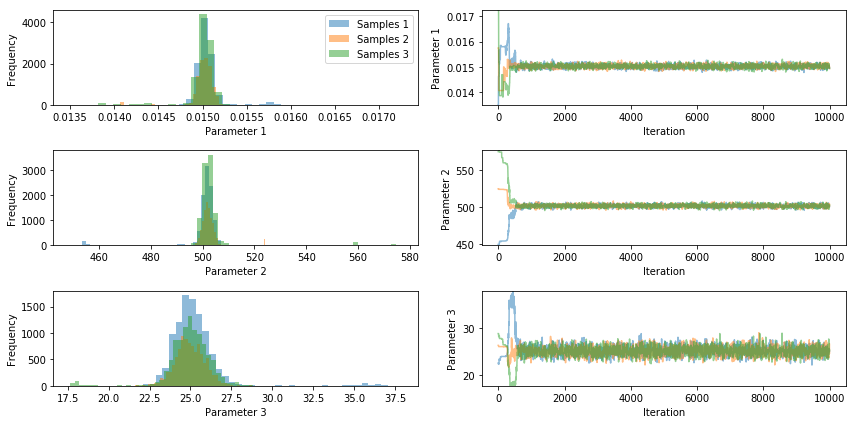

In [17]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [18]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

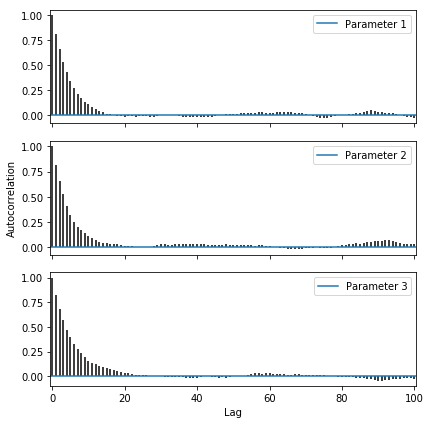

In [19]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

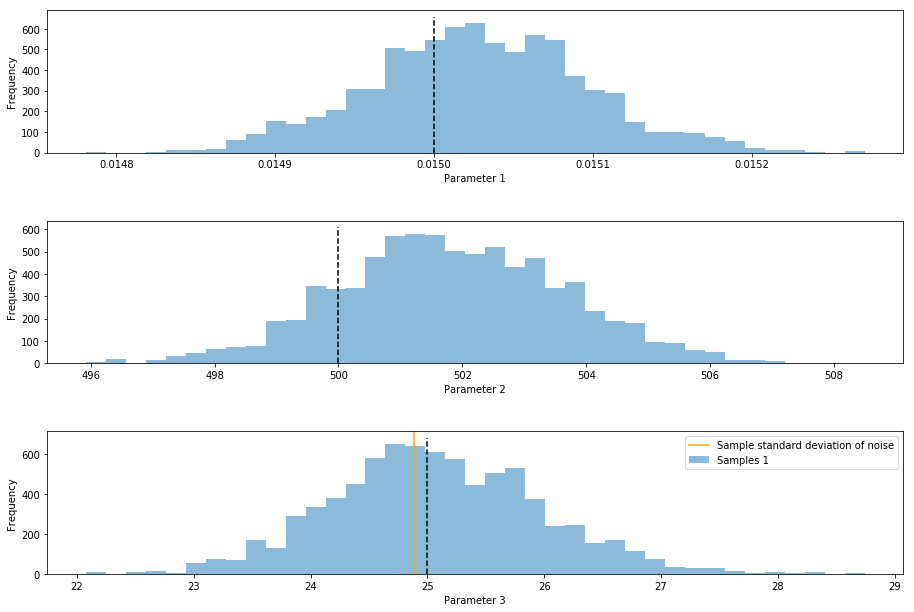

In [20]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [21]:
chain = chain[::10]

/home/chonlei/anaconda3/envs/matplotlib_build/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/chonlei/anaconda3/envs/matplotlib_build/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/chonlei/anaconda3/envs/matplotlib_build/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


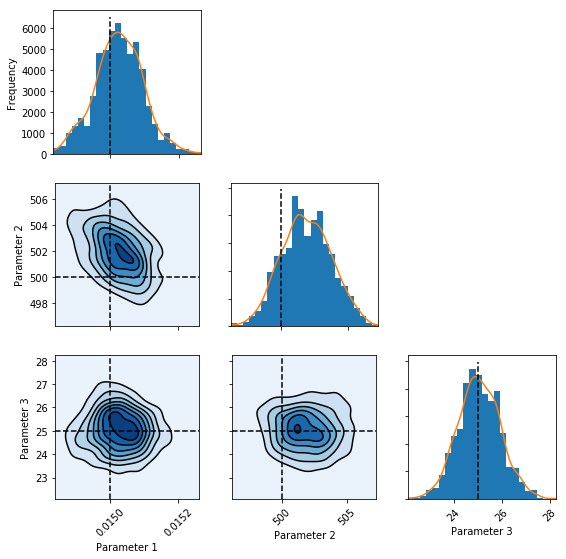

In [22]:
pints.plot.pairwise(chain, kde=True, ref_parameters=true_parameters)
plt.show()

As these plots show, we came pretty close to the original "true" values (represented by the blue line). 
But not exactly... Worse, the method seems to suggest a normal distribution but around the wrong point.
To find out what's going on, we can plot the log-posterior function near the true parameters:

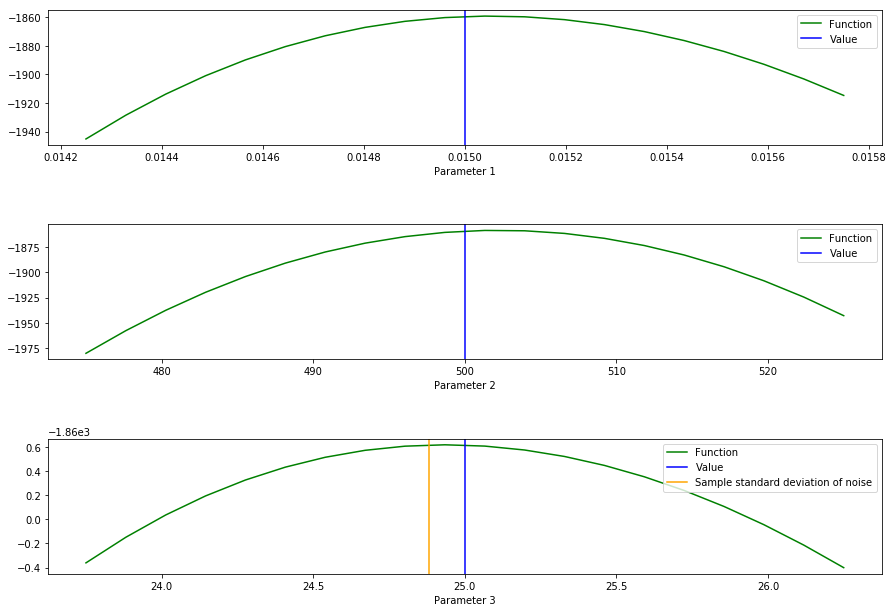

In [23]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior, true_parameters)

# Add a line showing the sample standard deviation of the generated noise
axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
axes[-1].legend()

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

As this plot (created entirely without MCMC!) shows, the MCMC method did well, but our estimate of the true parameters has become _biased_ by the stochastic noise! You can test this by increasing the number of sample points, which increases the size of the noise sample, and reduces the bias.

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

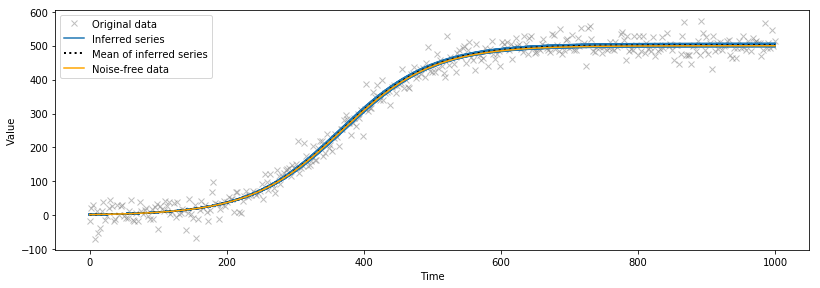

In [24]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()